In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sqlite3
%pip install requests pandas matplotlib seaborn sqlalchemy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<h1 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
 Top 5 "Paises con mayor poblacion del mundo"
</h1>

<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Comprobamos la API del World Bank
</h3>

In [20]:
base_url = "https://api.worldbank.org/v2"
test_country = "IND"
test_indicator = "NY.GDP.PCAP.CD"

url = f"{base_url}/country/{test_country}/indicator/{test_indicator}"
params = {
    "format": "json",
    "per_page": 20,
    "page": 1,
    "date": "2010:2024"}

headers = {"User-Agent": "Mozilla/5.0 (DataProject)"}

last_err = None
for attempt in range(1, 4):
    try:
        print(f"Intento {attempt}/3 ...")
        r = requests.get(url, params=params, headers=headers, timeout=90)
        print("Status code:", r.status_code)
        r.raise_for_status()
        payload = r.json()

        print(" OK. Metadatos:", payload[0])
        print(" Registros en esta pagina:", len(payload[1]))
        print(" Primer registro:")
        print(payload[1][0])
        break

    except Exception as e:
        last_err = e
        print(" Fallo:", repr(e))
        time.sleep(2)
else:
    raise last_err

Intento 1/3 ...
Status code: 200
 OK. Metadatos: {'page': 1, 'pages': 1, 'per_page': 20, 'total': 15, 'sourceid': '2', 'lastupdated': '2026-01-28'}
 Registros en esta pagina: 15
 Primer registro:
{'indicator': {'id': 'NY.GDP.PCAP.CD', 'value': 'GDP per capita (current US$)'}, 'country': {'id': 'IN', 'value': 'India'}, 'countryiso3code': 'IND', 'date': '2024', 'value': 2694.73780859961, 'unit': '', 'obs_status': '', 'decimal': 1}


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Configuracion del proyecto (paises, indicadores y rango de años)
</h3>

In [21]:
#  Paises (Top 5 mas poblados)
COUNTRIES = ["IND", "CHN", "USA", "IDN", "PAK"]

#  Indicadores (codigos World Bank)
INDICATORS = {
    "pop_total": "SP.POP.TOTL",                  # Poblacion total
    "gdp_per_capita": "NY.GDP.PCAP.CD",          # PIB per capita (USD actuales)
    "life_expectancy": "SP.DYN.LE00.IN",         # Esperanza de vida
    "co2_per_capita": "EN.GHG.CO2.PC.CE.AR5",    # CO2 per capita (AR5)
    "electricity_access": "EG.ELC.ACCS.ZS",      # Acceso a electricidad (%)
    "urban_population_pct": "SP.URB.TOTL.IN.ZS"} # Poblacion urbana (%)


#  Rango de años
START_YEAR = 2010
END_YEAR = 2024

print(" Paises:", COUNTRIES)
print(" Total indicadores:", len(INDICATORS))
print(" Ejemplo indicador:", list(INDICATORS.items())[0])
print(" Rango:", START_YEAR, "-", END_YEAR)

 Paises: ['IND', 'CHN', 'USA', 'IDN', 'PAK']
 Total indicadores: 6
 Ejemplo indicador: ('pop_total', 'SP.POP.TOTL')
 Rango: 2010 - 2024


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Funcion para descargar datos
</h3>

In [22]:
BASE_URL = "https://api.worldbank.org/v2"
HEADERS = {"User-Agent": "Mozilla/5.0 (DataProject)"}

def _fetch_page_with_retries(url, params, max_retries=3, sleep_secs=1):
    last_err = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, params=params, headers=HEADERS, timeout=90)
            r.raise_for_status()
            return r.json()
        except Exception as e:
            last_err = e
            time.sleep(sleep_secs)
    raise last_err

def fetch_all_pages(url, params, max_retries=3, sleep_secs=1):
    params = params.copy()
    params["page"] = 1

    first_payload = _fetch_page_with_retries(url, params, max_retries=max_retries, sleep_secs=sleep_secs)

    meta = first_payload[0] if len(first_payload) > 0 else {}
    pages = int(meta.get("pages", 1))

    all_rows = first_payload[1] if len(first_payload) > 1 and first_payload[1] is not None else []

    for page in range(2, pages + 1):
        params["page"] = page
        payload = _fetch_page_with_retries(url, params, max_retries=max_retries, sleep_secs=sleep_secs)
        rows = payload[1] if len(payload) > 1 and payload[1] is not None else []
        all_rows.extend(rows)

    return all_rows

<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Consulta de prueba
</h3>

In [23]:
test_country = "IND"
test_indicator = INDICATORS["gdp_per_capita"]

url = f"{BASE_URL}/country/{test_country}/indicator/{test_indicator}"
params = {
    "format": "json",
    "per_page": 20,
    "date": f"{START_YEAR}:{END_YEAR}"}

rows = fetch_all_pages(url, params)

print("Total registros descargados:", len(rows))
print("Primer registro (ejemplo):")
print(rows[0])

Total registros descargados: 15
Primer registro (ejemplo):
{'indicator': {'id': 'NY.GDP.PCAP.CD', 'value': 'GDP per capita (current US$)'}, 'country': {'id': 'IN', 'value': 'India'}, 'countryiso3code': 'IND', 'date': '2024', 'value': 2694.73780859961, 'unit': '', 'obs_status': '', 'decimal': 1}


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Pasamos la lista de registro a un Data Frame limpio
</h3>

In [24]:
def rows_to_df(rows):
    # Extraemos solo lo que queremos averiguar de cada Pais o de cada registro
    data = []
    for r in rows:
        data.append({
            "country": r.get("country", {}).get("id"),
            "year": r.get("date"),
            "value": r.get("value")})

    df = pd.DataFrame(data)

    # Limpieza minima
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    return df

# Test con lo que ya descargamos (IND + gdp_per_capita)
df_test = rows_to_df(rows)

print(" shape:", df_test.shape)
print(" años (min, max):", df_test["year"].min(), df_test["year"].max())
print(" nulos en value:", df_test["value"].isna().sum())
df_test.head(15)

 shape: (15, 3)
 años (min, max): 2010 2024
 nulos en value: 0


,country,year,value
0,IN,2024,2694.737809
1,IN,2023,2530.120313
2,IN,2022,2347.448294
3,IN,2021,2239.613844
4,IN,2020,1907.042516
5,IN,2019,2041.428637
6,IN,2018,1966.254552
7,IN,2017,1950.104683
8,IN,2016,1707.508929
9,IN,2015,1583.998159


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Descargamos el indicador para los 5 paises y armamos una sola tabla
</h3>

In [25]:
def fetch_indicator_for_countries(countries, indicator_code, start_year, end_year, per_page=20):

    all_dfs = []

    for c in countries:
        url = f"{BASE_URL}/country/{c}/indicator/{indicator_code}"
        params = {
            "format": "json",
            "per_page": per_page,
            "date": f"{start_year}:{end_year}"}

        rows = fetch_all_pages(url, params)
        df_c = rows_to_df(rows)
        df_c["country"] = df_c["country"].fillna(c)

        all_dfs.append(df_c)

    df_all = pd.concat(all_dfs, ignore_index=True)
    return df_all

#  Probamos con GDP per capita para los 5 paises
indicator_name = "gdp_per_capita"
indicator_code = INDICATORS[indicator_name]

df_gdp = fetch_indicator_for_countries(COUNTRIES, indicator_code, START_YEAR, END_YEAR)

print("Indicador:", indicator_name, indicator_code)
print("shape:", df_gdp.shape)
print("paises unicos:", df_gdp["country"].nunique(), df_gdp["country"].unique())
print("años (min, max):", df_gdp["year"].min(), df_gdp["year"].max())
print("nulos en value:", df_gdp["value"].isna().sum())
df_gdp.head()

Indicador: gdp_per_capita NY.GDP.PCAP.CD
shape: (75, 3)
paises unicos: 5 <StringArray>
['IN', 'CN', 'US', 'ID', 'PK']
Length: 5, dtype: str
años (min, max): 2010 2024
nulos en value: 0


,country,year,value
0,IN,2024,2694.737809
1,IN,2023,2530.120313
2,IN,2022,2347.448294
3,IN,2021,2239.613844
4,IN,2020,1907.042516


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Descargamos todos los indicadores y los guardamos en tablas separadas
</h3>

In [26]:
dfs = {}

for name, code in INDICATORS.items():
    print(f"Descargando: {name} ({code}) ...")
    df_ind = fetch_indicator_for_countries(COUNTRIES, code, START_YEAR, END_YEAR)
    dfs[name] = df_ind

    # Verificacion rapida por indicador
    print("  shape:", df_ind.shape, "| nulos value:", df_ind["value"].isna().sum())

print("\n Listo. Indicadores descargados:", list(dfs.keys()))

Descargando: pop_total (SP.POP.TOTL) ...
  shape: (75, 3) | nulos value: 0
Descargando: gdp_per_capita (NY.GDP.PCAP.CD) ...
  shape: (75, 3) | nulos value: 0
Descargando: life_expectancy (SP.DYN.LE00.IN) ...
  shape: (75, 3) | nulos value: 5
Descargando: co2_per_capita (EN.GHG.CO2.PC.CE.AR5) ...
  shape: (75, 3) | nulos value: 0
Descargando: electricity_access (EG.ELC.ACCS.ZS) ...
  shape: (75, 3) | nulos value: 5
Descargando: urban_population_pct (SP.URB.TOTL.IN.ZS) ...
  shape: (75, 3) | nulos value: 0

 Listo. Indicadores descargados: ['pop_total', 'gdp_per_capita', 'life_expectancy', 'co2_per_capita', 'electricity_access', 'urban_population_pct']


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Vemos la muestra de uno de ellos
</h3>

In [28]:
# Poblacion total
dfs["pop_total"].head(10)

,country,year,value
0,IN,2024,1450935791
1,IN,2023,1438069596
2,IN,2022,1425423212
3,IN,2021,1414203896
4,IN,2020,1402617695
5,IN,2019,1389030312
6,IN,2018,1374659064
7,IN,2017,1359657400
8,IN,2016,1343944296
9,IN,2015,1328024498


<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Grafico 1: <br>Evolucion del PIB per capita por años <br>📅 2010–2024 <span style="opacity:.55;">•</span> 📈 PIB per cápita
</h3>

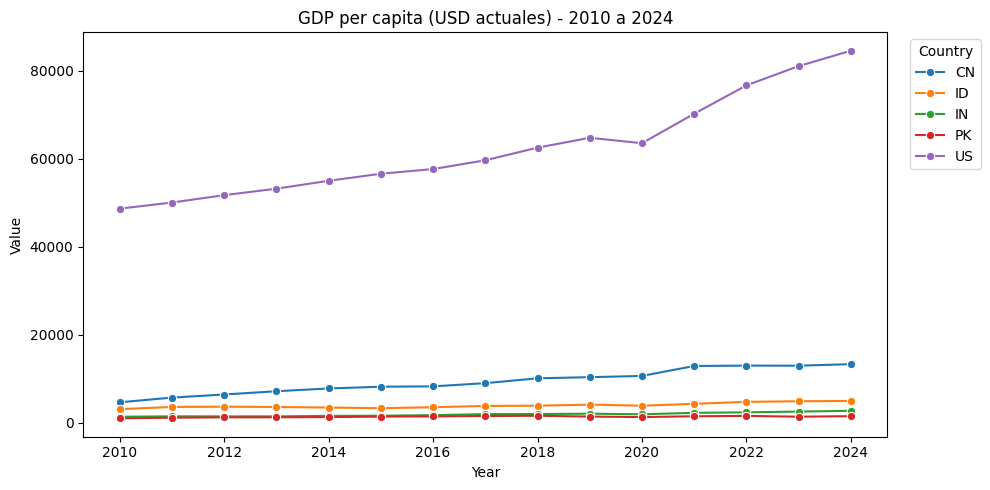

 Filas usadas para el grafico: 75


In [13]:
df_gdp = dfs["gdp_per_capita"].copy()

# Para graficar quitamos nulos en value
df_plot = df_gdp.dropna(subset=["value"]).copy()

# Aseguramos orden por año
df_plot = df_plot.sort_values(["country", "year"])

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_plot, x="year", y="value", hue="country", marker="o")
plt.title("GDP per capita (USD actuales) - 2010 a 2024")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(" Filas usadas para el grafico:", df_plot.shape[0])

En este grafico estamos viendo como cambia el PIB per capita con el tiempo (de 2010 a 2024) para los 5 paises.

- Cada linea es un pais.
- Si la linea sube, significa que en promedio el pais genero mas dinero por persona (en USD actuales).
- Si la linea baja, significa que ese valor bajo en ese periodo.

<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Grafico 2: <br>Relacion entre PIB per capita y CO<sub>2</sub> per capita<br>📅 año 2024 <span style="opacity:.55;">•</span> 📈 PIB - CO<sub>2</sub>  per capita
</h3>

In [29]:
# Tomamos los 2 dataframes
df_gdp = dfs["gdp_per_capita"].copy()
df_co2 = dfs["co2_per_capita"].copy()

# Filtramos solo 2024
df_gdp_2024 = df_gdp[df_gdp["year"] == 2024][["country", "year", "value"]].rename(columns={"value": "gdp_per_capita"})
df_co2_2024 = df_co2[df_co2["year"] == 2024][["country", "year", "value"]].rename(columns={"value": "co2_per_capita"})

# Unimos por country y year
df_scatter = pd.merge(df_gdp_2024, df_co2_2024, on=["country", "year"], how="inner")

# Quitamos nulos por si acaso
df_scatter = df_scatter.dropna(subset=["gdp_per_capita", "co2_per_capita"])

print("Paises con datos en 2024:", df_scatter["country"].unique())
print("shape:", df_scatter.shape)
df_scatter

Paises con datos en 2024: <StringArray>
['IN', 'CN', 'US', 'ID', 'PK']
Length: 5, dtype: str
shape: (5, 4)


,country,year,gdp_per_capita,co2_per_capita
0,IN,2024,2694.737809,2.173652
1,CN,2024,13303.148154,9.315089
2,US,2024,84534.040784,13.619569
3,ID,2024,4925.430488,2.865040
4,PK,2024,1478.772780,0.811832


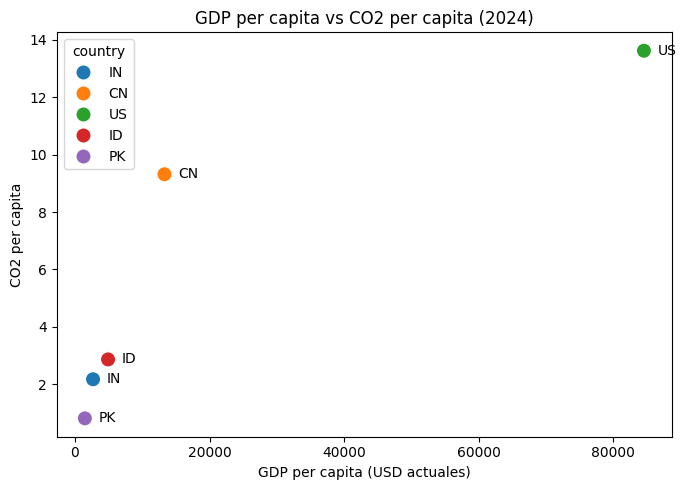

In [ ]:
# Etiquetas con el codigo del pais para que se entienda cada punto
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_scatter, x="gdp_per_capita", y="co2_per_capita", hue="country", s=120)

for _, row in df_scatter.iterrows():
    plt.annotate(
        row["country"],
        (row["gdp_per_capita"], row["co2_per_capita"]),
        textcoords="offset points",
        xytext=(10, 0),
        ha="left",
        va="center")

plt.title("GDP per capita vs CO2 per capita (2024)")
plt.xlabel("GDP per capita (USD actuales)")
plt.ylabel("CO2 per capita")
plt.tight_layout()
plt.show()

En este grafico estamos comparando dos cosas en un mismo año:

- En el eje X: PIB per capita (cuanto dinero promedio por persona).
- En el eje Y: CO<sub>2</sub> per capita (cuantas emisiones promedio por persona).

Cada punto es un pais. Sirve para ver si en general los paises con mas PIB por persona tambien tienden a emitir mas CO<sub>2</sub> por persona.

Una interpetacion simple seria:
- Si un pais esta mas a la derecha, tiene mas PIB per capita.
- Si un pais esta mas arriba, emite mas CO<sub>2</sub> per capita.
- Si dos paises quedan muy cerca, significa que en ese año tuvieron valores parecidos en esos dos indicadores.

<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Grafico 3: <br>Evolucion de la poblacion total<br>📅 2010 - 2024 <span style="opacity:.55;">•</span> 📈 Poblacion total
</h3>

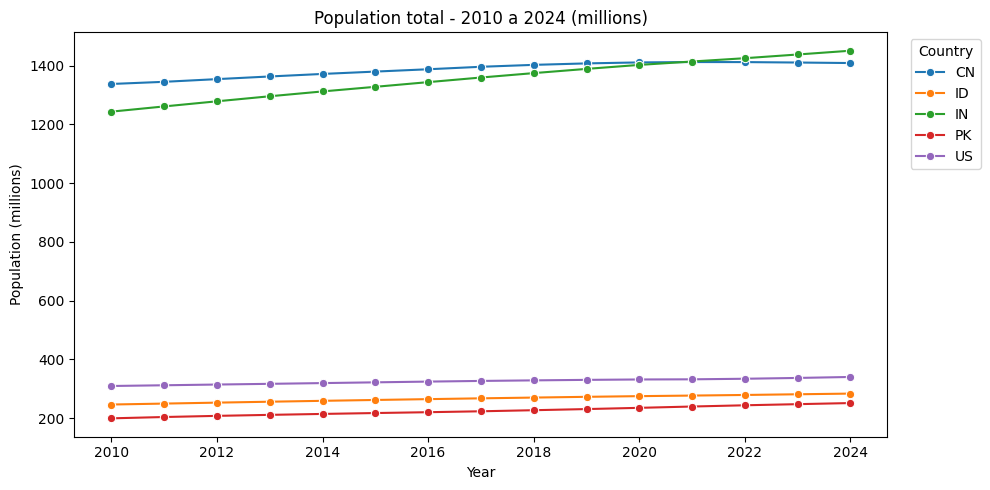

In [17]:
df_pop = dfs["pop_total"].copy()
df_pop_plot = df_pop.dropna(subset=["value"]).copy()
df_pop_plot = df_pop_plot.sort_values(["country", "year"])
df_pop_plot["value_millions"] = df_pop_plot["value"] / 1_000_000

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_pop_plot, x="year", y="value_millions", hue="country", marker="o")
plt.title("Population total - 2010 a 2024 (millions)")
plt.xlabel("Year")
plt.ylabel("Population (millions)")
plt.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

En este grafico vemos como ha cambiado la poblacion total entre 2010 y 2024 en los 5 paises mas poblados.

- Cada linea es un pais.
- Si la linea sube, significa que ese pais crecio en poblacion en esos años.
- Otra cosa que podemos resaltar es el punto entre 2020 y 2022, donde India supero a China como el pais con mayor poblacion.

<h3 style="
  color: #ffffff;
  background: linear-gradient(135deg, #0b0f12 0%, #2b3136 55%, #4a535a 100%);
  padding: 12px 16px;
  border-radius: 10px;
  text-align: center;
  box-shadow: 0 10px 28px rgba(0,0,0,.18);
  border: 1px solid rgba(255,255,255,.10);
  border-top: 5px solid #22c55e;
">
Guardar los resultados en una base de datos SQLite
</h3>


In [30]:
conn = sqlite3.connect("world_bank_analysis.db")

for name, df in dfs.items():
    table_name = f"indicator_{name}"
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print(" Guardado:", table_name, "| filas:", len(df))

sample = pd.read_sql("SELECT * FROM indicator_gdp_per_capita LIMIT 5", conn)
sample

 Guardado: indicator_pop_total | filas: 75
 Guardado: indicator_gdp_per_capita | filas: 75
 Guardado: indicator_life_expectancy | filas: 75
 Guardado: indicator_co2_per_capita | filas: 75
 Guardado: indicator_electricity_access | filas: 75
 Guardado: indicator_urban_population_pct | filas: 75


,country,year,value
0,IN,2024,2694.737809
1,IN,2023,2530.120313
2,IN,2022,2347.448294
3,IN,2021,2239.613844
4,IN,2020,1907.042516
